## Project: Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning

In this project we want to build a deep learning model trained on chest X-ray images from children to classify whether an X-ray indicates signs of pneumonia. An accurate and timely diagnosis of the disease could be the difference in saving many lives.



![](https://images.unsplash.com/photo-1530497610245-94d3c16cda28?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1964&q=80)
__Photo by Owen Beard on Unsplash__

### Loading the data

The data was collected by researchers from the University of California, San Diegoand is compressed as a tar.gz file. When uncompressed the dataset has the following directory structure: test (NORMAL and PNEUMONIA) and train (NORMAL and PNEUMONIA). Since there's no separate validation dataset available to us, we'll create a validation dataset from the training dataset.

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt
%matplotlib inline
import random

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [2]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)
        
extract_tar_gz('C:/Users/Denisa/Desktop/Project Apps/project 28/xray_dataset.tar.gz', '.')

We ll set a batch size of 128 and set the size of the images as 256X256 pixels to minimize the risk of running into an Out Of Memory error.

In [3]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size))

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


### Data Exploration

Next, let's explore our training and test sets by displaying some of the images and their associated labels. This will help us get an idea of what kind of model we should start with, and what data augmentation approaches could benefit the model.

In [4]:
#class_names of the training data
train_set.class_names

['NORMAL', 'PNEUMONIA']

Displaying different images in the first batch of the training set:

In [5]:
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

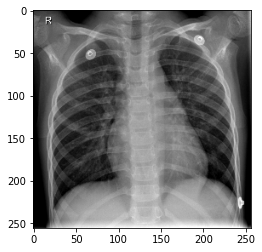

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


In [6]:
idx = 0
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

Displaying different images in the first batch of the test set:

In [7]:
test_set_elem = test_set.take(1)
for images, labels in test_set_elem:
    images = images.numpy()

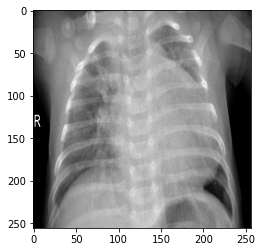

Test Set Image Label: [0. 1.]


In [8]:
idx = 15
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Test Set Image Label: {labels[idx]}")

The images are all rotated at different angles (given the differences between how the X-rays were taken, the images could be rotated, at the very least, as part of data augmentation).We can see as a conclusion to our eda that our images have 3 channels (even though they look like greyscale images)

### First Model: Simple CNN I

We will start with a small model and train it for a few epochs to gauge how the model performs on the dataset.After that, we can experiment by adding more layers to the model, tuning any hyperparameters, and re-training the model for a reasonable number of epochs till we notice any overfitting. If we do notice any overfitting, we can then add regularization or choose to tune hyperparameters further to try to improve the model's performance.

Our first version of the model will contain:

* 1 convolutional layer

* 1 max pooling layer

* 1 flatten layer

* 1 fully-connected layer

An output layer with the number of units equal to the number of classes

In [9]:
first_model = models.Sequential()

first_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(16, activation='relu'))
first_model.add(layers.Dense(2))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

first_model.summary()

first_model.fit(train_set_normalized, epochs=5, validation_data=validation_set_normalized)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 16)                1016080   
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1016562 (3.88 MB)
Trainable params: 1016562 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

We will continue to implement some regularization techniques and more fully-connected layers.
We will implement the following regularization approaches:
* add 2 data augumentation layers: RandomZoom and RandomRotation to introduce variations 
* add an EarlyStopping callback that would stop the training if the validation loss didn't decrease for three consecutive epochs (the restore_best_weights argument ensured that the model would use weights from the epoch with the lowest validation loss only)
* add more fully-connected layers increasing complexity of the model
* Reducing the learning rate helped the model to converge
* Add batch normalziation layers for their regularizing effect

In [10]:
first_model = models.Sequential()

first_model.add(layers.RandomZoom(height_factor=0.1))
first_model.add(layers.RandomRotation(factor=0.2))

first_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.BatchNormalization(momentum=0.9))


first_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.BatchNormalization(momentum=0.9))


first_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.BatchNormalization(momentum=0.9))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(256, activation='relu'))
first_model.add(layers.BatchNormalization(momentum=0.9))

first_model.add(layers.Dense(64, activation='relu'))
first_model.add(layers.BatchNormalization(momentum=0.9))
first_model.add(layers.Dense(32, activation='relu'))
first_model.add(layers.BatchNormalization(momentum=0.9))
first_model.add(layers.Dense(2))

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
first_model.build((None, img_size, img_size, 3))

first_model.summary()
first_model.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 63, 63, 128)       512       
 Normalization)                                                  
                                                      

We got an accuracy of 95% on the training set and 94% on the validation set.

### Second Model: Transfer Learning

We'll build our second model using transfer learning. We will use ResNet v2 pre-trained model. Although ImageNet unfortunately doesn't contain classes that are a reasonable match for X-rays  that doesn't imply that the pre-trained weights can't be useful feature extractors. Ideally, we'd want to use a model trained on a similar dataset, but finding such a model can be a difficult task. We'll stick to what's available to us for now. We will include the same data augmentation layers as the first model. Instead of flattening the layers, we used a global pooling average layer followed by three fully-connected layers and an output layer. We will include an early stopping callback like with the previous model.

In [11]:
#Create an instance of a ResNet-based pre-trained model
base_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)
#Freeze all the layers of the base model.
base_model.trainable = False
#Create an input layer and preprocess it according to the preprocessing used for the pre-trained model
input_layer = Input(shape=(img_size, img_size, 3))

preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)
#Create a layer using the base model and the preprocessed input layer
features_layer = base_model(preprocessed_input_layer, training=False)
#Add a global average pooling layer.
global_pooling = layers.GlobalAveragePooling2D()(features_layer)
#Add some fully-connected layers.
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)
#Add a fully-connected output layer.
output = layers.Dense(2)(fc3)

second_model = Model(inputs=input_layer, outputs=output)

second_model.summary()
# adding an EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                             

We experimented with the number of layers to unfreeze for fine-tuning. Unfreezing layers beyond the last 10 either had diminishing returns or it worsened the model's performance.

In [14]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping_callback])


Epoch 1/5
33/33 [==============================] - 596s 18s/step - loss: 0.1003 - accuracy: 0.9599 - val_loss: 0.0947 - val_accuracy: 0.9685
Epoch 2/5
33/33 [==============================] - 644s 19s/step - loss: 0.0708 - accuracy: 0.9747 - val_loss: 0.0856 - val_accuracy: 0.9723
Epoch 3/5
33/33 [==============================] - 644s 19s/step - loss: 0.0651 - accuracy: 0.9759 - val_loss: 0.0809 - val_accuracy: 0.9713
Epoch 4/5
33/33 [==============================] - 625s 19s/step - loss: 0.0649 - accuracy: 0.9754 - val_loss: 0.1810 - val_accuracy: 0.9302
Epoch 5/5
5/5 [==============================] - 37s 7s/step - loss: 0.4051 - accuracy: 0.8750


The second model, using transfer learning led to an accuracy of 97 on the validation set, it outperforms the first model (94) but not by a significant margin.

In [15]:
second_model_test_loss, second_model_test_acc = second_model.evaluate(test_set)
print(f"Test set accuracy of second model: {second_model_test_acc}")

Test set accuracy of second model: 0.875


### Conclusion

In this project we:

* Loaded in and explored a dataset containing images of chest X-rays

* Built and trained two CNN classifiers to detect whether an X-ray showed signs of pneumonia to assist hospitals in diagnosing patients, particularly children.

* Experimented with the model architectures to try to improve each model's performance

 We started with a simple CNN model (1 convolutional layer, 1 max pooling layer,1 flatten layer,1 fully-connected layer) which we developed further by adding more layers and implementing some regularization techniques like adding data augumentation, an Earlystopping callback, a batch normalization layer. The second model was built using transfer learning. We used the ResNet v2 pre-trained model, hoping that the pre-trained weights can't be useful feature extractors for our model.  We also fine-tuned the model unfreezing some of the layers of the base model and retraining the new model with a much smaller learning rate.